In [46]:
from TicTacToe import Board, GameTools as gt
from Sample import random_samples

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.cluster import KMeans

## Data Generation and Vectorization

In order to train models, data is needed. I wrote a function which allows for a data set to be randomly generated based on a number of parameters. This function will be used throughout this notebook.

In [47]:
# example of generating random samples using some of the parameters to adjust settings
# this data set will contain 1000 samples
data = random_samples(n_samples=1000, save_file=False, rand_first_player=True, shuffled=True)

# this returns a pandas DataFrame
data.head()

,board,winner,1,2,3,4,5,6,7,8,9
0,"[[0, -1, -1], [-1, -1, 1], [-1, -1, -1]]",-1,7,-3,0,0,0,0,0,0,0
1,"[[1, -1, -1], [0, -1, -1], [-1, -1, -1]]",-1,-5,3,0,0,0,0,0,0,0
2,"[[-1, 0, -1], [-1, -1, -1], [-1, -1, 1]]",-1,-4,9,0,0,0,0,0,0,0
3,"[[-1, -1, -1], [-1, -1, -1], [1, 0, -1]]",-1,7,-8,0,0,0,0,0,0,0
4,"[[0, 1, 0], [0, 1, 1], [1, 0, -1]]",-1,-5,7,-5,4,-3,6,-8,7,0


We have a lot of information compressed into a small table.

The first two columns are rarely used, but are kept for data validation. They are:
- "board": the game board in the form of a matrix. 'X' = 1, 'O' = 0, and an open space is represented with -1
- "winner": indicates if the match was completed, and if so, who won

The numbered columns are an encoded representation of a full match of TTT that I set up. These numbers represent all moves made during a match and their order. This can then be vectorized to be easily fed into a learning algorithm. Let's look at how to do that.

In [48]:
# data is in the form of a pandas DataFrame. We can extract any columns we want to use for training data.
# we use the column keys (1, 2, 3, etc...) to extract them from the 'data' variable
train_X = data[[x for x in range(1, 10)]]

# looking at the extracted data
train_X.head()

,1,2,3,4,5,6,7,8,9
0,7,-3,0,0,0,0,0,0,0
1,-5,3,0,0,0,0,0,0,0
2,-4,9,0,0,0,0,0,0,0
3,7,-8,0,0,0,0,0,0,0
4,-5,7,-5,4,-3,6,-8,7,0


In [49]:
# vectorizing the data can be done with the 'values' attribute. This returns a numpy nd.array
# we assign this to a new matrix, X
X = train_X.values

# looking at the resulting matrix
X[:5]

array([[ 7, -3,  0,  0,  0,  0,  0,  0,  0],
       [-5,  3,  0,  0,  0,  0,  0,  0,  0],
       [-4,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 7, -8,  0,  0,  0,  0,  0,  0,  0],
       [-5,  7, -5,  4, -3,  6, -8,  7,  0]], dtype=int64)

The training data has now be vectorized. This allows for fitting and predicting to be computationally more efficient, and sets up an easy structure for getting predictions back from a model during implementation.

## K-Means Clustering: Finding a K value

When clustering, it's difficult to know how many clusters, if any, to expect the data to fall into. In order to effectively identify the proper amount, iterative testing and comparison of Summed Squared Error (SSE) is necessary. We will use a graphing library to observe the results.

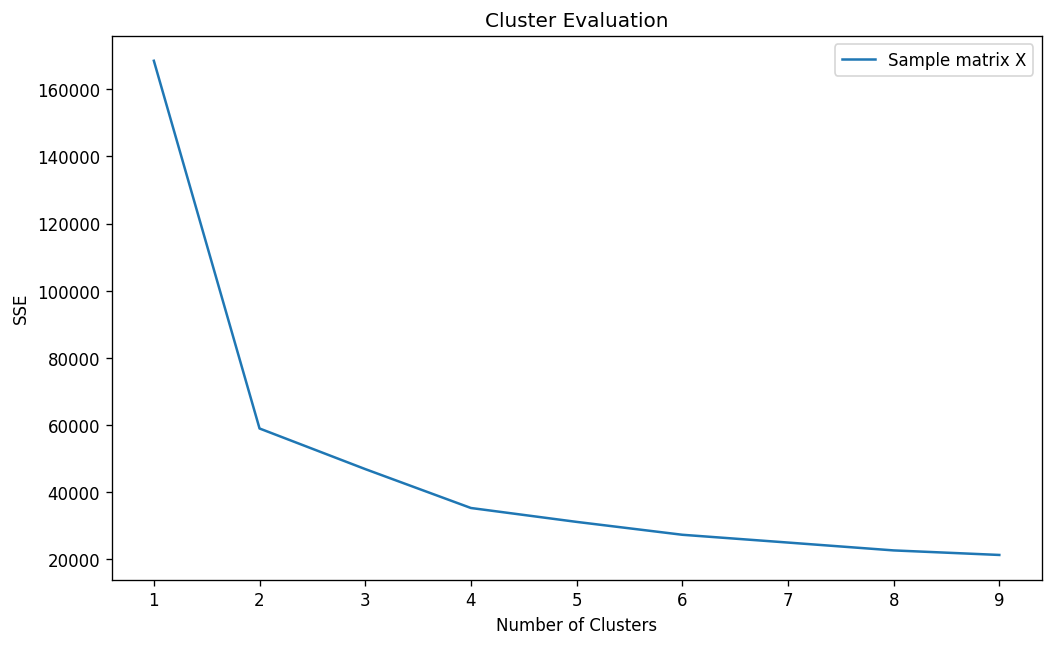

In [50]:
# initializing the plot and adjusting settings
plt.figure(figsize=(10, 6), dpi=120)

sse = dict()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=2500).fit(X)
    sse[k] = kmeans.inertia_ # sum of squared euclidian distance from each point to its closest centroid
plt.plot(list(sse.keys()), list(sse.values()), label=f"Sample matrix X")

plt.title("Cluster Evaluation")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.legend(loc="upper right")
plt.show()

There is an 'elbow' at k=2 clusters where the Sum of Squared Error (SSE) has a sharp change in direction. This indicates that the SSE is beinning to converge at k=2, which implies that our data is most likely split into 2 clusters.

It is worth noting the SSE scales linearly with the size of the training set, so the raw value of SSE is arbitrary. Instead, we can look at the variance.

We'll compare the variance of our models for different sized data sets to determine the optimal amount of training samples.

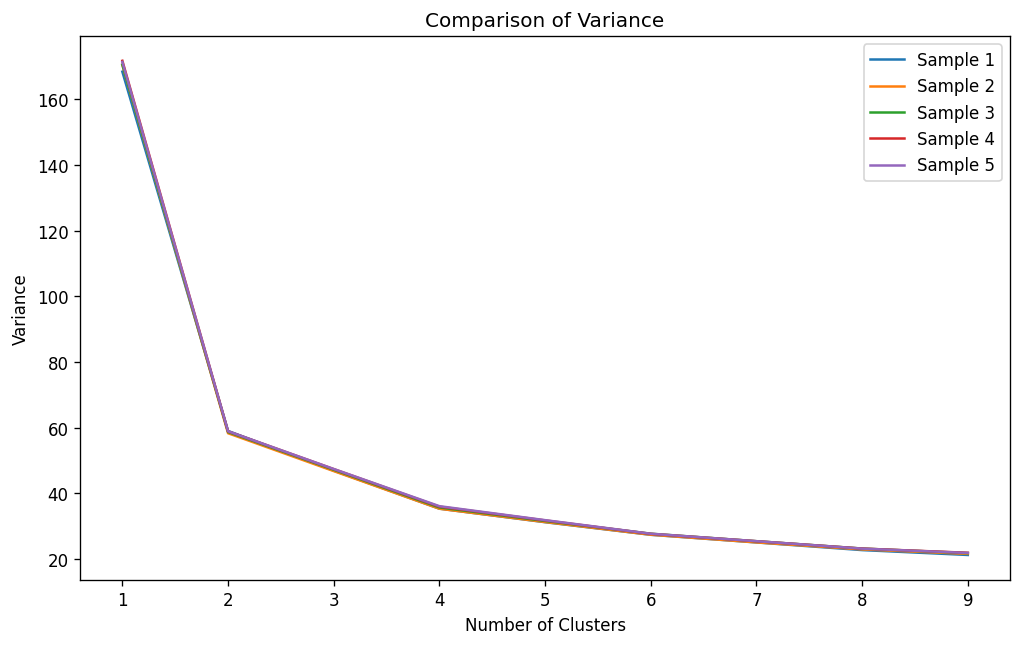

Variance in each model at k=2 clusters: [58.99267235527663, 58.30192443183955, 58.66012072434491, 58.87157608350281, 58.897899175995114]


In [51]:
# creating our data sets
data_a = random_samples(n_samples=1000)
data_b = random_samples(n_samples=5000)
data_c = random_samples(n_samples=10000)
data_d = random_samples(n_samples=25000)
data_e = random_samples(n_samples=50000)

A = data_a[[x for x in range(1, 10)]].values
B = data_b[[x for x in range(1, 10)]].values
C = data_c[[x for x in range(1, 10)]].values
D = data_d[[x for x in range(1, 10)]].values
E = data_e[[x for x in range(1, 10)]].values

abcde = [A, B, C, D, E]

# initializing our plot
plt.figure(figsize=(10, 6), dpi=120)

agg_var = list()
# iteratively building models witht the different data sets
for idx, vec in enumerate(abcde):
    variance = dict()
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=2500).fit(vec)
        variance[k] = kmeans.inertia_ / len(vec) # sum of squared euclidian distance from each point to its closest centroid
    plt.plot(list(variance.keys()), list(variance.values()), label=f"Sample {idx + 1}")
    agg_var.append(variance)

plt.title("Comparison of Variance")
plt.xlabel("Number of Clusters")
plt.ylabel("Variance")
plt.legend(loc="upper right")
plt.show()
print("Variance in each model at k=2 clusters:", [x[2] for x in agg_var])

It is clear that variance of the model remains roughly the same, regardless of the size of the data set. This indicates that even with only 1000 training examples, our model identifies 2 effective centroids for classification. We will use n=1000 to train a model.

## K-Means Clustering: Training and Saving a model

Since we now have evidence indicating that k=2 and we know n=1000 is sufficient for training, we can construct a model to classify boards of Tic Tac Toe!

We will use SciKit-Learn to construct a simple model with the default parameters. Rather than loading in an already generated dataset, we will generate a new one.

In [52]:
# data set with 1000 samples
data_z = random_samples(n_samples=1000)
Z = data_z[[x for x in range(1, 10)]].values

# instantiating the KMeans model
model = KMeans(n_clusters=2)

# fitting the model to our Z data matrix
model.fit(Z)

# looking at our SSE and variance
model.inertia_, model.inertia_ / len(Z)

(58992.67235527663, 58.992672355276625)

We now have a trained model that can be used for classification. We still do not know what the classes are, however. This will need to be determined through further testing.

For now, we will just demonstrate how to use this model for classification.

In [53]:
# looking at the classifications of the first 100 elements of our smaller data matrix, X
model.predict(X)[:100]

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

The predictions from the model assign each sample to either class '1' or class '0'. 

It is assumed for now that each class indicates that a match is in-favor of player 'X' or player 'O'. Later, we will be using these classifications to operate a decision tree.

Now that the model is trained and ready for live testing, we will save it into a binary file. This binary file will be loadable into any program to make predictions.

In [54]:
# using pickle library to write a new .sav file in binary in our specific directory
pickle.dump(model, open("model_binaries/example_kmeans.sav", "wb"))

This binary file can then be loaded in a similar way and then used for predictions.

In [55]:
model = pickle.load(open("model_binaries/example_kmeans.sav", "rb"))
model.predict(X)[:100]

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

## Decision Tree

Rather than using an algorirthm like minimax to generate and evaluate a decision tree of sorts, we can instead use the data from our K-Means clustering model to more quickly extrapolate the next best move given a game of Tic Tac Toe.

Using the coordinates of the centroids from the model, we can choose the move which has the smallest euclidian distance from our desired class' centroid.

In [56]:
# each (unknown) class has a center at the following coordinates
c0 = model.cluster_centers_[0]
c1 = model.cluster_centers_[1]

c0, c1

(array([ 6.06967213, -5.16188525,  4.47131148, -3.64959016,  2.98360656,
        -2.06557377,  1.21106557, -0.51844262,  0.        ]),
 array([-5.92773438,  5.28515625, -4.24023438,  3.63867188, -2.9765625 ,
         1.80273438, -0.99023438,  0.30859375,  0.        ]))

Let's assume we want to optimize our decisions in favor of cluster 0.

We'll use the coordinates for c0 to measure distance. A function that measures the distance will look like this.

In [57]:
# a function that calculates the euclidian distance between two 9-dimensional points

def distance(point: np.ndarray, centroid: np.ndarray) -> float:
    dist = np.subtract(centroid, point)
    dist = dist**2
    dist = np.sqrt(np.sum(dist))
    
    return dist

Given a board, we will have some number of open spaces, t. For each t, we can make a move to a different spot on the board.

We will generate t unique boards and then convert them into our vector format.

In [58]:
# let this be the board we are evaluating
board = [-1, 5, -6, 0, 0, 0, 0, 0, 0, 0]

# this is equivalent to the following matrix
board_matrix = [
    [0, -1, -1],
    [-1, 1, 0],
    [-1, -1, -1]
]

print(gt.string_board(board_matrix))

 O |   |   
-----------
   | X | O 
-----------
   |   |   


There are 6 choices for the next move by player 'X'.

In [59]:
# our possible next moves in vectorized form
m0 = [-1, 5, -6, 2, 0, 0, 0, 0, 0]
m1 = [-1, 5, -6, 3, 0, 0, 0, 0, 0]
m2 = [-1, 5, -6, 4, 0, 0, 0, 0, 0]
m3 = [-1, 5, -6, 7, 0, 0, 0, 0, 0]
m4 = [-1, 5, -6, 8, 0, 0, 0, 0, 0]
m5 = [-1, 5, -6, 9, 0, 0, 0, 0, 0]

# converting into a numpy matrix
moves = np.array([m0, m1, m2, m3, m4, m5])

# visually verifying
moves

array([[-1,  5, -6,  2,  0,  0,  0,  0,  0],
       [-1,  5, -6,  3,  0,  0,  0,  0,  0],
       [-1,  5, -6,  4,  0,  0,  0,  0,  0],
       [-1,  5, -6,  7,  0,  0,  0,  0,  0],
       [-1,  5, -6,  8,  0,  0,  0,  0,  0],
       [-1,  5, -6,  9,  0,  0,  0,  0,  0]])

We can now iteratively compare these moves by their euclidian distance to our desired point, choosing the move with the lowest value.

In [60]:
# helper variables
min_dist = 0
opt_move = 0

for idx, p in enumerate(moves):
    dist = distance(p, c0)
    
    if min_dist == 0 or dist < min_dist:
        min_dist = dist
        opt_move = idx
        
moves[opt_move], min_dist

(array([-1,  5, -6,  2,  0,  0,  0,  0,  0]), 17.59870377317895)

We've identified the next best move!